In [1]:
from keras import utils
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

# Creation de GAN Convolutif Profond

## Entrainement sur le ds mnist

### Préprocess 

In [2]:
mnist = fetch_openml("mnist_784")

c:\Python311\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
mnist_df = np.array(mnist.data)
labels = np.array(mnist.target.tolist())
images = mnist_df.reshape(70000,28,28)

In [4]:
train_ds = tf.data.Dataset.from_tensor_slices(images)
train_ds = train_ds.map(lambda x: tf.expand_dims(x, axis=-1))
train_ds = train_ds.batch(100)
train_ds

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None)>

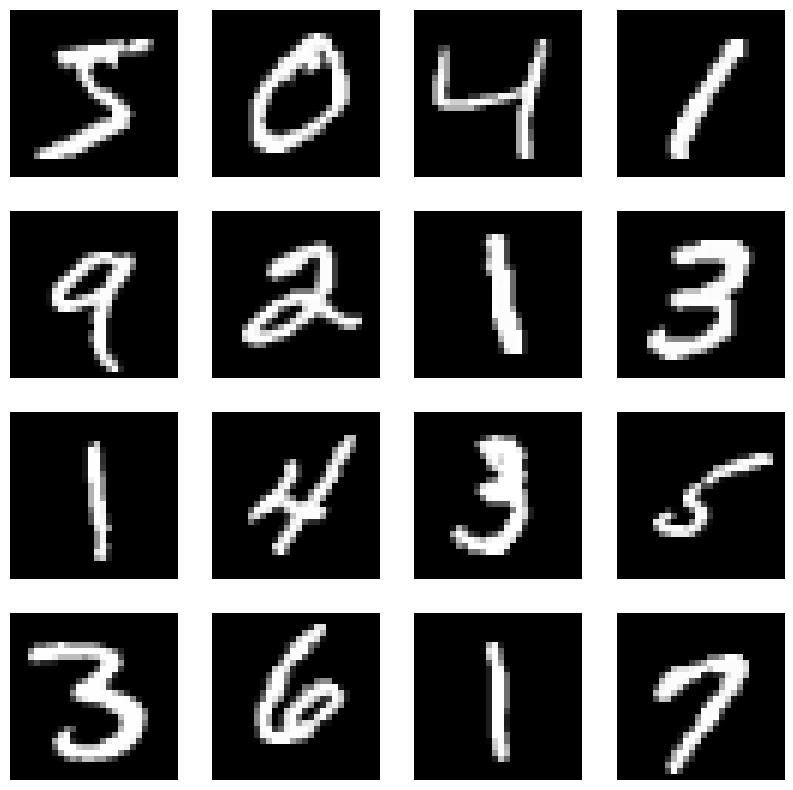

In [8]:
def plot_images(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for images in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')  # 'squeeze' pour enlever la dimension du canal
            plt.axis("off")
    plt.show()
    
plot_images(train_ds, 16)

### cration des modèles generatif et de classification

In [5]:
from keras.layers import Conv2D, Lambda, MaxPooling2D, Input # convolution layers
from keras.layers import Dense, Dropout, Flatten, LeakyReLU # core layers
from keras.layers import BatchNormalization
from keras.layers import Reshape, Conv2DTranspose, ReLU

#### Discriminator
le discriminateur prédit si une image est réel ou généré, donc ici les données sont labélisé [1;0] donc un CNN.

In [59]:
discriminator_input = Input(shape=(28,28,1))
x= Conv2D(32, kernel_size=(3, 3), activation="relu")(discriminator_input)
x= MaxPooling2D(pool_size=(2, 2))(x)
x= Conv2D(64, kernel_size=(3, 3), activation="relu")(x)
x= MaxPooling2D(pool_size=(2, 2))(x)
x= Flatten()(x)
x= Dropout(0.5)(x)
discriminator_output = Dense(1, activation="sigmoid")(x)

discriminator = tf.keras.models.Model(discriminator_input,discriminator_output,)

In [60]:
discriminator.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │         1,601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,417 (79.75 KB)

 Trainable params: 20,417 (79.75 KB)

 Non-trainable params: 0 (0.00 B)

#### Generator
Le generateur est un modèle qui prend un vecteur en entré et qui retourne une image de la même taille que les valeur d'entré du discriminateur. Ici la vecteur d'entré est un entier entre 0 et 9, et il retourne une matrice 28x28x1

In [57]:
generator_input = Input(shape=(10,))
x= Reshape((1,1,10))(generator_input)
x = Dense(3*3*128, use_bias=False)(x)
x= BatchNormalization(momentum=0.9)(x)
x= LeakyReLU(0.2)(x)

x = Dense(7*7*64, use_bias=False)(x)
x= BatchNormalization(momentum=0.9)(x)
x= LeakyReLU(0.2)(x)
x = Reshape((7, 7, 64))(x)

x= Conv2DTranspose(
    32, kernel_size=4, strides=2, padding="same", use_bias = False
)(x)
x= BatchNormalization(momentum=0.9)(x)
x= LeakyReLU(0.2)(x)

generator_output = Conv2DTranspose(
    1,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation = "tanh"
)(x)

generator = tf.keras.models.Model(generator_input,generator_output)

In [58]:
generator.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_10 (Reshape)            │ (None, 1, 1, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1, 1, 1152)     │        11,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1, 1, 1152)     │         4,608 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 1, 1, 1152)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1, 1, 3136)     │     3,612,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1, 1, 3136)     │        12,544 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 1, 1, 3136)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_11 (Reshape)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 14, 14, 32)     │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │           512 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,674,752 (14.02 MB)

 Trainable params: 3,666,112 (13.99 MB)

 Non-trainable params: 8,640 (33.75 KB)

## Creation de la class DCGAN

La class permet de crée un GAN avec le générateur le dicriminateur, les données, le vecteur latent, et le générateur de vecteur latent

In [55]:
class DCGAN(tf.keras.models.Model):
    def __init__(self, discriminator, generator, latent_dim, latent_vector_generator, latent_vector_params):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.latent_vector_generator = latent_vector_generator
        self.latent_vector_params = latent_vector_params

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.d_real_acc_metric = tf.keras.metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = tf.keras.metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = tf.keras.metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")
        self.g_acc_metric = tf.keras.metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = self.latent_vector_generator(
            shape=(batch_size,self.latent_dim), 
            **self.latent_vector_params
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + 0.1 * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - 0.1 * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

modèle GAN pour mnist

**à faire ça prend un temps fou**

In [85]:
dcgan_mnist = DCGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=10,
    latent_vector_generator= tf.random.uniform,
    latent_vector_params= {
        'minval': 0,
        'maxval': 10,
        'dtype': tf.int32
    }
)

dcgan_mnist.compile(
    d_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.999
    ),
    g_optimizer= tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.999
    )
)

dcgan_mnist.fit(train_ds,epochs = 10)

Epoch 1/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 320s 451ms/step - d_acc: 0.5000 - d_fake_acc: 0.0000e+00 - d_loss: -1868471.5000 - d_real_acc: 1.0000 - g_acc: 1.0000 - g_loss: 0.0000e+00
Epoch 2/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 318s 455ms/step - d_acc: 0.5000 - d_fake_acc: 0.0000e+00 - d_loss: -3821862.0000 - d_real_acc: 1.0000 - g_acc: 1.0000 - g_loss: 0.0000e+00
Epoch 3/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 322s 460ms/step - d_acc: 0.5000 - d_fake_acc: 0.0000e+00 - d_loss: -7245423.5000 - d_real_acc: 1.0000 - g_acc: 1.0000 - g_loss: 0.0000e+00
Epoch 4/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 355s 507ms/step - d_acc: 0.5000 - d_fake_acc: 0.0000e+00 - d_loss: -12508967.0000 - d_real_acc: 1.0000 - g_acc: 1.0000 - g_loss: 0.0000e+00
Epoch 5/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 337s 481ms/step - d_acc: 0.5000 - d_fake_acc: 0.0000e+00 - d_loss: -19946852.0000 - d_real_acc: 1.0000 - g_acc: 1.0000 - g_loss: 0.0000e+00
Epoch 6/10
700/700 ━━━━━━━━━━━━━━━━━━━━ 331s 473ms/step - d_acc: 0.5000 - d_fake_acc: 0.0000e+00 - d_lo

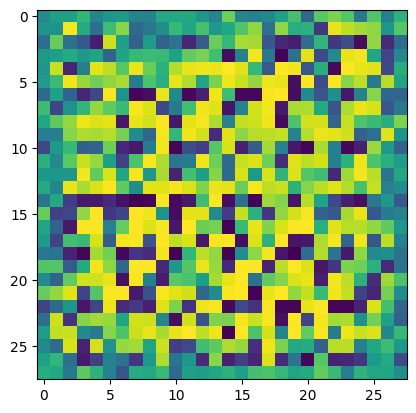

In [88]:
discriminator(generator(tf.random.uniform(shape=(1,10),minval=0,maxval=10,dtype=tf.int32),training=False))
plt.imshow(generator(tf.random.uniform(shape=(1,10),minval=0,maxval=10,dtype=tf.int32),training=False)[0])

## Utilisation du dataset de piéces de LEGO

Ce dataset est plus complé que mnist et le fait d'avoir des images de piéces en 3D donne un défi de génération

https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images

In [90]:
train_database = tf.keras.utils.image_dataset_from_directory('./dataset/',
                                                    labels=None,
                                                    color_mode="grayscale",
                                                    image_size=(256,256),
                                                    batch_size=128,
                                                    shuffle=True,
                                                    seed=42,
                                                    interpolation="bilinear")

Found 40000 files.


In [92]:
train_database

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None)>

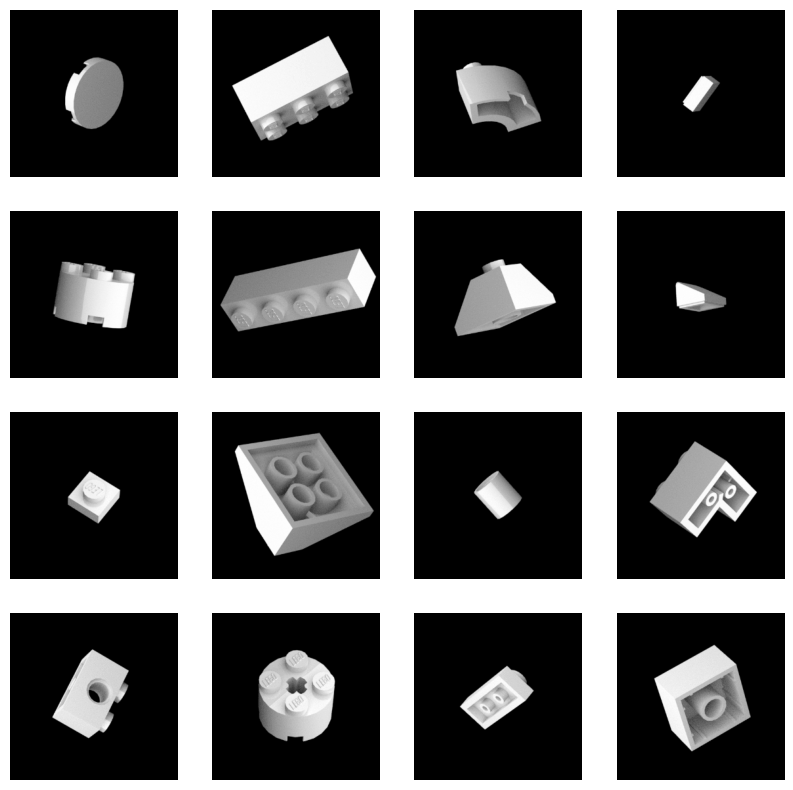

In [21]:
plot_images(train_database, 16)

In [96]:
def preprocess(img):
    img = (tf.cast(img,"float32")-127.5)/127.5
    return img

In [98]:
train = train_database.map(lambda x: preprocess(x))

ValueError: Attempt to convert a value (<_MapDataset element_spec=TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None)>) with an unsupported type (<class 'tensorflow.python.data.ops.map_op._MapDataset'>) to a Tensor.

#### Discriminator

In [20]:
discriminator_inputs = Input(shape=(28,28,1))
x= Conv2D(64, kernel_size=4, strides= 2, padding= "same", use_bias= False)(discriminator_inputs)
x= LeakyReLU(0.2)(x)
x= Dropout(0.3)(x)
x= Conv2D(128,kernel_size=4,strides=2,padding="same",use_bias=False)(x)
x= BatchNormalization(momentum= 0.9)(x)
x= LeakyReLU(0.2)(x)
x= Dropout(0.3)(x)
x= Conv2D(256,kernel_size=4,strides=2,padding="same",use_bias=False)(x)
x= BatchNormalization(momentum= 0.9)(x)
x= LeakyReLU(0.2)(x)
x= Dropout(0.3)(x)
x= Conv2D(512,kernel_size=4,strides=2,padding="same",use_bias=False)(x)
x= BatchNormalization(momentum= 0.9)(x)
x= LeakyReLU(0.2)(x)
x= Dropout(0.3)(x)
x= Conv2D(1,kernel_size=4,strides=2,padding="valid",use_bias=False,activation='sigmoid')(x)
discriminator_output = Flatten()(x)

discriminator = tf.keras.models.Model(discriminator_inputs,discriminator_output)

NameError: name 'Input' is not defined

In [7]:
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 512)      │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 1)        │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,765,312 (10.55 MB)

 Trainable params: 2,763,520 (10.54 MB)

 Non-trainable params: 1,792 (7.00 KB)

#### Generator

In [9]:
generator_input = Input(shape=(100,))
x= Reshape((1,1,100))(generator_input)
x= Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias = False
)(x)
x= BatchNormalization(momentum=0.9)(x)
x= LeakyReLU(0.2)(x)

x= Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias = False
)(x)
x= BatchNormalization(momentum=0.9)(x)
x= LeakyReLU(0.2)(x)

x= Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias = False
)(x)
x= BatchNormalization(momentum=0.9)(x)
x= LeakyReLU(0.2)(x)

x= Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias = False
)(x)
x= BatchNormalization(momentum=0.9)(x)
x= LeakyReLU(0.2)(x)

generator_output = Conv2DTranspose(
    1,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation = "tanh"
)(x)

generator = tf.keras.models.Model(generator_input,generator_output)

In [10]:
generator.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 1, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 512)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 1)      │         1,024 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,576,576 (13.64 MB)

 Trainable params: 3,574,656 (13.64 MB)

 Non-trainable params: 1,920 (7.50 KB)

### entrainement du modèle

**C'est encore plus long que pour mnist impossible je le fait**

In [12]:
dcgan = DCGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=100,
    latent_vector_generator=tf.random.normal,
    latent_vector_params={}
)

dcgan.compile(
    d_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.999
    ),
    g_optimizer= tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1 = 0.5, beta_2 = 0.999
    )
)

dcgan.fit(train,epochs = 300)

Epoch 1/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 720s 2s/step - d_loss: 0.3969 - g_loss: 3.2202
Epoch 2/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 702s 2s/step - d_loss: 0.2213 - g_loss: 2.9923
Epoch 3/300
 45/313 ━━━━━━━━━━━━━━━━━━━━ 11:05 2s/step - d_loss: 0.2184 - g_loss: 3.0027

KeyboardInterrupt: 